In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, LeakyReLU, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
train = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/train.csv")
meal_info = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/meal_info.csv")
fulfilment_center_info = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/fulfilment_center_info.csv")
test = pd.read_csv("/Users/karnavivek/Downloads/Food Demand/data/test.csv")

merge1 = pd.merge(train, fulfilment_center_info, how='left')
merge2 = pd.merge(merge1, meal_info, how='left')

merge2[['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured']] = merge2[['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured']].astype('object')

df_weekly_orders = merge2.groupby(['week'])['num_orders'].sum().reset_index()
df_weekly_orders.set_index(df_weekly_orders['week'], inplace=True)
df_weekly_orders.drop(columns='week', inplace=True)

In [32]:
train_orders  = df_weekly_orders [:110]
val_orders = df_weekly_orders[110:130]
test_orders = df_weekly_orders[130:]
train_orders.shape, val_orders.shape, test_orders.shape

((110, 1), (20, 1), (15, 1))

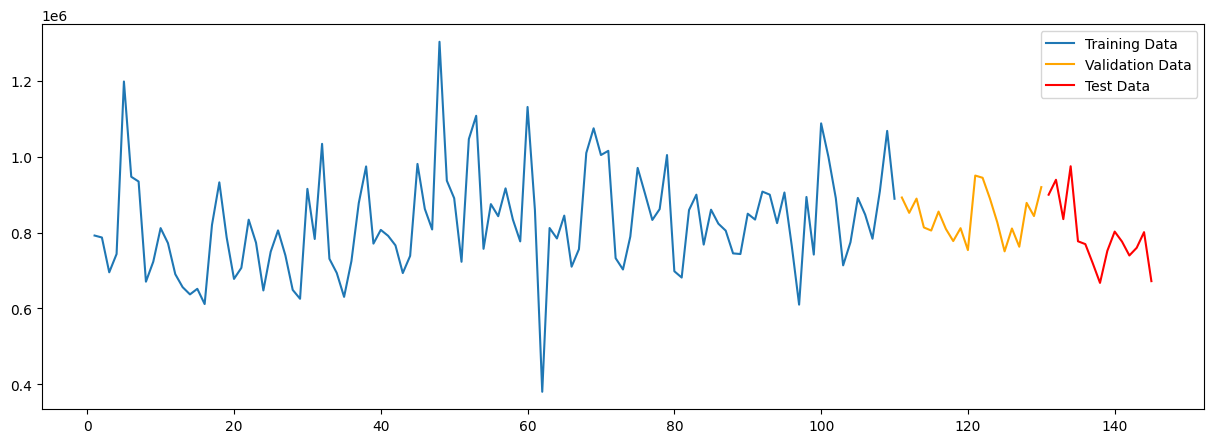

In [34]:
plt.figure(figsize=(15,5))
plt.plot(train_orders, label = 'Training Data')
plt.plot(val_orders, color='orange', label='Validation Data')
plt.plot(test_orders, color='red', label='Test Data')
plt.legend()
plt.show()

In [6]:
df_weekly_orders

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675
...,...
141,776240
142,739661
143,759926


In [35]:
''' Scale the data - (0, 1)'''
scaler = MinMaxScaler(feature_range=(0, 1))

train_orders = scaler.fit_transform(train_orders)
val_orders  = scaler.fit_transform(val_orders)
test_orders = scaler.fit_transform(test_orders)

In [37]:
#shape of the datasets
print(f'Shape of Training set: {train_orders.shape}')
print(f'Shape of Validation set : {val_orders.shape}')
print(f'Shape of Testing set : {test_orders.shape}')

Shape of Training set: (110, 1)
Shape of Validation set : (20, 1)
Shape of Testing set : (15, 1)


In [40]:
'''Let's Create Dataset for LSTM model, i.e. converting time series into inputs and label'''
def create_dataset(df, window_size):
    X_data, y_data = [], []

    for i in range(window_size, len(df)):
        X_data.append(df[i-window_size:i, 0])
        y_data.append(df[i,0])

    return np.array(X_data), np.array(y_data)

window_size = 5
X_train, y_train = create_dataset(train_orders, window_size)
X_val, y_val = create_dataset(val_orders, window_size)
X_test, y_test = create_dataset(test_orders, window_size)


In [41]:
print("Shape of Training input: " + str(X_train.shape))
print("Shape of Training labels: " + str(y_train.shape))
print("Shape of Validation input: " + str(X_val.shape))
print("Shape of Validation labels: " + str(y_val.shape))
print("Shape of Testing input: " + str(X_test.shape))
print("Shape of Testing labels: " + str(y_test.shape))

Shape of Training input: (105, 5)
Shape of Training labels: (105,)
Shape of Validation input: (15, 5)
Shape of Validation labels: (15,)
Shape of Testing input: (10, 5)
Shape of Testing labels: (10,)


In [42]:
'''Reshaping the data to tensorflow can understand'''

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print("Shape of train input: " + str(X_train.shape))
print("Shape of train labels: " + str(y_train.shape))
print("Shape of validation input: " + str(X_val.shape))
print("Shape of validation labels: " + str(y_val.shape))
print("Shape of test input: " + str(X_test.shape))
print("Shape of test labels: " + str(y_test.shape))

Shape of train input: (105, 1, 5)
Shape of train labels: (105,)
Shape of validation input: (15, 1, 5)
Shape of validation labels: (15,)
Shape of test input: (10, 1, 5)
Shape of test labels: (10,)


In [56]:
'''Creating LSTM Model using tensorflow.keras'''

model = Sequential()
model.add(LSTM(128, input_shape = (1, window_size), return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(Dense(1, 'linear'))
# model.compile(loss = 'mse', optimizer='adam')

In [57]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 1, 128)         │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 1, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,665 (975.25 KB)

 Trainable params: 249,665 (975.25 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
cp = ModelCheckpoint('models_cp/model.keras', save_best_only = True)

# early_stopping = EarlyStopping(monitor = 'val_loss', 
#                                patience = 2, 
#                                mode = 'min')

model.compile(loss=MeanSquaredError(), 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=[MeanAbsoluteError()])

model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle = False, epochs=100, callbacks=[cp])

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.1915 - mean_absolute_error: 0.4133 - val_loss: 0.2565 - val_mean_absolute_error: 0.4032
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1887 - mean_absolute_error: 0.4102 - val_loss: 0.2540 - val_mean_absolute_error: 0.4009
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1867 - mean_absolute_error: 0.4077 - val_loss: 0.2515 - val_mean_absolute_error: 0.3986
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1841 - mean_absolute_error: 0.4046 - val_loss: 0.2488 - val_mean_absolute_error: 0.3963
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1807 - mean_absolute_error: 0.4004 - val_loss: 0.2461 - val_mean_absolute_error: 0.3939
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1782 - mean_absolute_error: 0.3972 - val_loss: 0.2434 - val_mean_absolute_error: 0.3916
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1748 - mean_absolute_error: 0.3929 - val_loss: 0.240

In [60]:
from tensorflow.keras.models import load_model

model = load_model('models_cp/model.keras')

In [429]:
X_val.shape

(10, 1, 25)

In [78]:
'''Lets predict now'''

train_pred = model.predict(X_train)#.flatten()
# train_results = pd.DataFrame(data={"Train Predictions":train_pred,
#                                    "Actuals": y_train})
# train_results

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [79]:
val_pred = model.predict(X_val)#.flatten()
test_pred = model.predict(X_test)#.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [80]:
train_pred.shape, X_train.shape

((105, 1, 1), (105, 1, 5))

In [84]:
'''Inverse Transforming the data'''
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform([y_train])

val_pred = scaler.inverse_transform(val_pred)
y_val = scaler.inverse_transform([y_val])

test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform([y_test])

ValueError: Found array with dim 3. None expected <= 2.

In [406]:
y_train[0]

array([809224.82750121, 787299.36286756, 756922.44160443, 749107.84355615,
       845748.05060256, 801696.16595877, 885340.25888139, 784274.03466242,
       771832.4640651 , 750788.80362078, 782250.81726504, 833235.49576778,
       865466.0054289 , 797613.73915628, 809676.06063514, 804455.21995859,
       796055.75178472, 771721.82196727, 786822.46876516, 867676.51457019,
       828158.95638147, 810045.97849234, 975072.        , 852940.12022088,
       837542.87261856, 781641.28594898, 889542.32578363, 910012.78017895,
       793049.41936144, 832333.02949993, 821703.72314358, 846188.6194379 ,
       818769.37473576, 799552.30868364, 917752.06161847, 827320.80916447,
       667343.        , 811314.36350542, 802127.40353284, 822243.27000017,
       777324.57783693, 792720.49240193, 877266.0518144 , 898999.22581417,
       875491.44587781, 879182.95948525, 784812.24848168, 774856.79249225,
       803821.36071138, 864197.62041581, 841591.97348797, 818419.11917907,
       827962.33337629, 8

In [83]:
y_train[0]

0.6142819084419184

In [77]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_pred[0]))
print('Train Score: %.2f RMSE' % (train_score))
val_score = np.sqrt(mean_squared_error(y_val[0], val_pred[0]))
print('Test Score: %.2f RMSE' % (val_score))

InvalidParameterError: The 'y_true' parameter of mean_squared_error must be an array-like. Got 0.6142819084419184 instead.

In [434]:
X_train.shape, X_val.shape, y_train[0].shape, train_pred[:,0].shape, y_val[0].shape, val_pred[:,0].shape

((85, 1, 25), (10, 1, 25), (85,), (85,), (10,), (10,))

In [435]:
week_train = list(range(1, len(X_train)+1))
week_train

trainActual = pd.DataFrame({'Number of Orders':y_train[0]})
trainActual.index = week_train

trainPred = pd.DataFrame({'Number of Orders': train_pred[:,0]})
trainPred.index = week_train

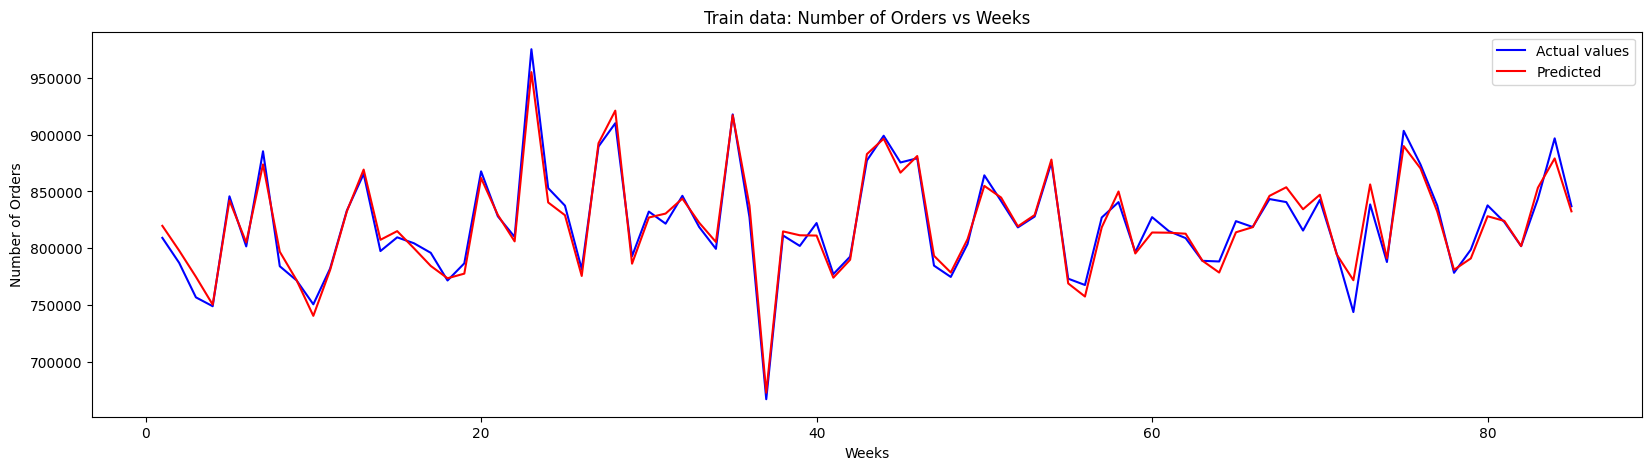

In [436]:
plt.figure(figsize=(20,5))
plt.plot(trainActual, color='blue', label='Actual values')
plt.plot(trainPred, color='red', label='Predicted')
plt.title('Train data: Number of Orders vs Weeks')
plt.xlabel('Weeks')
plt.ylabel('Number of Orders')
plt.legend(loc='best')
plt.show()

In [437]:
week_val = list(range(len(X_train)+1, len(X_train)+len(X_val)+1))
week_val

[86, 87, 88, 89, 90, 91, 92, 93, 94, 95]

In [438]:
valActual = pd.DataFrame({'Number of Orders': y_val[0]})
valActual.index = week_val

valPred = pd.DataFrame({'Number of Orders': test_pred[:,0]})
valPred.index = week_val

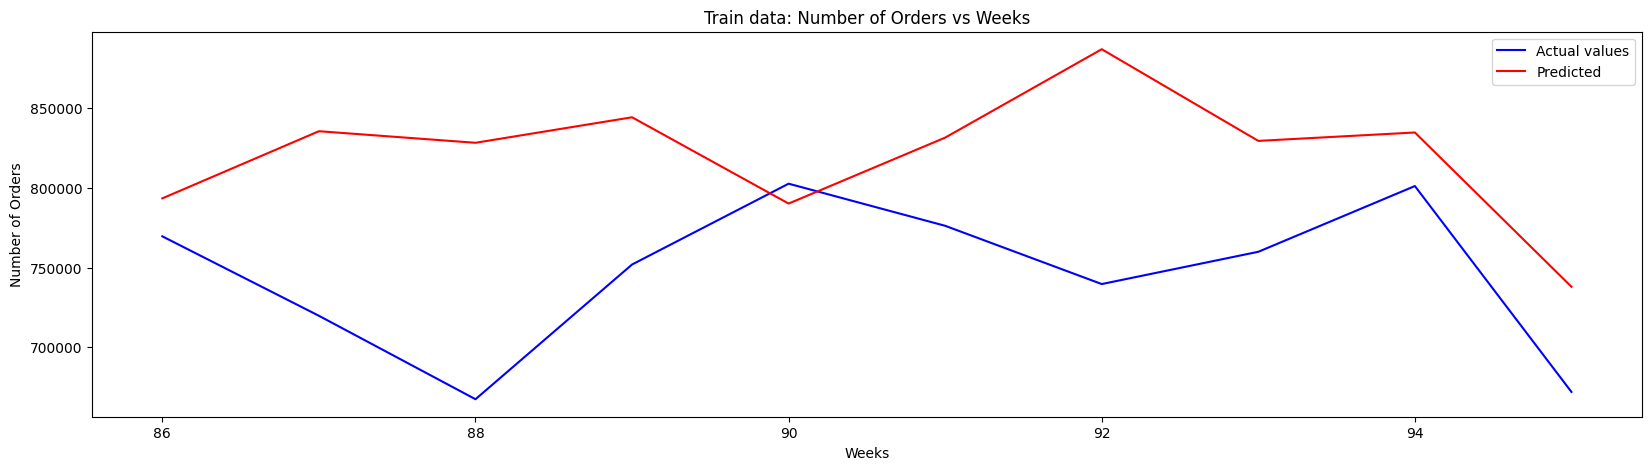

In [439]:
plt.figure(figsize=(20,5))
plt.plot(valActual, color='blue', label='Actual values')
plt.plot(valPred, color='red', label='Predicted')
plt.title('Train data: Number of Orders vs Weeks')
plt.xlabel('Weeks')
plt.ylabel('Number of Orders')
plt.legend(loc='best')
plt.show()

In [440]:
valPred

,Number of Orders
86,793472.7500
87,835634.8125
88,828373.5000
89,844385.1875
90,790205.5000
91,831622.2500
92,887123.1250
93,829559.9375
94,834840.9375
95,737964.0000
